In [1]:
import time
import socket
import datetime
import numpy as np
import pandas as pd
import json
from dateutil.parser import parse
import warnings
warnings.filterwarnings("ignore")

from data.mongo_storage import MongoStorage

from rebalance.single_simulation import PortfolioSimulation
from rebalance.full_simulation import FullPortfolioSimulation, StatisticalTest
from simulation.run_multiprocessing import run_simulation
from google.google_sheet import get_settings, get_gworksheet, worksheet_to_pandas

import task.google_task as gt
import cxtpy

from rebalance.pc_allocate_second_layer import knn_cluster, single_cluster, two_layer_weight

from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import plotly.express as px
from plotly.offline import plot
from rebalance.pc_helper import *

from rebalance.analyze_replicate import *
from rebalance.load_trpei import load_parse_trpei

In [2]:
startdate = datetime.datetime(2014,1,1)
enddate = datetime.datetime(2020,1,1)

In [3]:
# TRPEI
target_ret_dict, tdf = load_parse_trpei()
tdf.index[0], tdf.index[-1]

(Timestamp('2014-01-31 00:00:00'), Timestamp('2020-01-31 00:00:00'))

In [4]:
# asset = "EURUSD"
# m = MongoStorage()
# spy_meta = m.FilterAndGetMetadata({"Name":{"$in": [asset]}})
# spy = m.LoadAllSeriesFromId([j["_id"] for j in spy_meta])[0]
# tdf = spy.df.copy()
# target_ret_dict = get_monthly_ret_dict(tdf, tdf.columns[0], startdate, enddate)


In [1]:
sim_kwargs = {"n": 100, "seed": 1, "disable_exclude_1": 0, "corr_threshold": 0.8, "disable_exclude_2": 0, "disable_exclude_3": 0, "select_method": "RankPctSharpe", "top_pct": 0.35, 
              "allocate_method": "TwoLayer_KNN_RP", "n_cluster": 3, 
                "select_lookback": 45, "allocate_lookback": 45, "evaluate_forward": 45, "startdate": datetime.datetime(2018,1,1), "enddate": datetime.datetime(2019,6,1)
             }

FPS_2 = FullPortfolioSimulation(sim_name = "test_replicate_-1_1")

fps_kwargs = {"disable_exclude_1": 1, "disable_exclude_2": 1, "disable_exclude_3": 1, "disable_exclude_4": 1, "seed": 123,
                "select_method": "All", 
                 "allocate_method": "Replicate_LookbackSquareError", "target_ret": "VARIABLE",
                 "constrain_weight": 0,
                  "lowerbound": -1, "upperbound": 1
#                  "allocate_method": "CRP",
                }
# filter_dict = {"SeriesType": "Benchmark", "Name":{"$nin": [asset]}}
filter_dict = {"SeriesType": "Replicate_Basket_2c"}
FPS_2.SingleMonthlySimulationWithTarget(startdate, enddate, target_ret_dict, filter_dict, **fps_kwargs)
mr_df, cp_df_2, weight_df = FPS_2.AnalyzeMSWT(tdf, startdate, enddate)

weight_df.to_csv("TRPEI_weightbound_-1_to_1.csv")
print(cp_df_2.corr())
cp_df_2.plot()


NameError: name 'datetime' is not defined

Successful.
Successful.
          ACTUAL        IS       OOS
ACTUAL  1.000000  0.992391  0.176220
IS      0.992391  1.000000  0.199445
OOS     0.176220  0.199445  1.000000


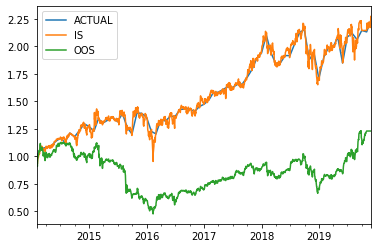

In [12]:
FPS_1 = FullPortfolioSimulation(sim_name = "test_replicate_0_1")

fps_kwargs = {"disable_exclude_1": 1, "disable_exclude_2": 1, "disable_exclude_3": 1, "disable_exclude_4": 1, "seed": 123,
                "select_method": "All", 
                 "allocate_method": "Replicate_LookbackSquareError", "target_ret": "VARIABLE",
                 "constrain_weight": 0,
                  "lowerbound": 0, "upperbound": 1
#                  "allocate_method": "CRP",
                }
# filter_dict = {"SeriesType": "Benchmark", "Name":{"$nin": [asset]}}
filter_dict = {"SeriesType": "Replicate_Basket_2c"}
FPS_1.SingleMonthlySimulationWithTarget(startdate, enddate, target_ret_dict, filter_dict, **fps_kwargs)
FPS_1.SingleMonthlySimulationWithTarget(startdate, enddate, target_ret_dict, filter_dict, **fps_kwargs)
mr_df, cp_df, weight_df = FPS_1.AnalyzeMSWT(tdf, startdate, enddate)

weight_df.to_csv("TRPEI_weightbound_0_to_1.csv")
print(cp_df.corr())
cp_df.plot()


          OOS_x     OOS_y
OOS_x  1.000000  0.827834
OOS_y  0.827834  1.000000


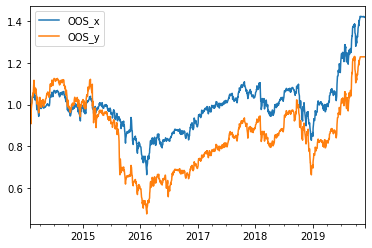

In [19]:
fdf = pd.merge(cp_df_2[["OOS"]], cp_df[["OOS"]], left_index = True, right_index = True)
print(fdf.corr())
fdf.plot()

## TO_REMOVE

In [12]:
m = MongoStorage()

In [ ]:
from rebalance.single_simulation import *
from rebalance.optimize_metrics import * 
from rebalance.pc_optimize import *


a1 = datetime.datetime(2019,3,1)
a2 = datetime.datetime(2019,4,1)
f1 = datetime.datetime(2019,4,1)
f2 = datetime.datetime(2019,5,1)

spy_meta = m.FilterAndGetMetadata({"Name":{"$in": ["SPY"]}})
spy = m.LoadAllSeriesFromId([j["_id"] for j in spy_meta])[0]
target_ret_is = np.prod(spy.df.loc[a1:a2]+1)-1
target_ret_oos = np.prod(spy.df.loc[f1:f2]+1)-1

single_kwargs = {"disable_exclude_1": 1, "disable_exclude_2": 1, "disable_exclude_3": 1, "disable_exclude_4": 1,
                "s1": a1, "s2": a2,
                "a1": a1, "a2": a2,
                "f1": f1, "f2": f2,
                "select_method": "all", 
                 "allocate_method": "Replicate_LookbackSquareError", "target_ret": target_ret_is,
                 "constrain_weight": 0
#                  "allocate_method": "CRP",
                }

kwargs = single_kwargs
s1 = kwargs.get("s1")
s2 = kwargs.get("s2")
a1 = kwargs.get("a1")
a2 = kwargs.get("a2")
f1 = kwargs.get("f1")
f2 = kwargs.get("f2")

filter_dict = {"SeriesType": "Benchmark", "Name":{"$nin": ["SPY"]}}

ps = PortfolioSimulation(kwargs = single_kwargs, filter_dict = filter_dict)
strategy_list = ps.meta_df["Name"].values
rseries_list = ps.meta_df["rs"].values

# ps.is_metrics, ps.oos_metrics
ps.meta_df
# print(ps.meta_df["weight"].sum())
# weights = ps.meta_df["weight"]
allocate_back_df = rdf = get_df_combined_from_rs_list(rs_list = rseries_list, d1 = a1, d2 = a2).fillna(0)
# target_ret = 0.006
fun = Weights_MinTargetErr(allocate_back_df, target_ret_is)
w, res = OptimizeWeights(allocate_back_df, fun, lowerbound = -1, upperbound = 1, 
                         method = None, tol = 1e-8, constraint = False)


In [ ]:
ps.meta_df

In [ ]:
target_ret_is, target_ret_oos

In [ ]:
ps.is_portfolio_df.tail()

In [ ]:
ps.portfolio_df.tail()

In [ ]:
ps.is_portfolio_df.pcret.plot()

In [ ]:
ps.portfolio_df.pcret.plot()

In [ ]:
# res
ps.meta_df
# ps.is_metrics, ps.oos_metrics

In [ ]:
weights = np.array(weights)
returns = np.array(rdf.values)

In [ ]:
err = P_RET_TARGET_SQERR(weights, returns, 0.01)
err

In [ ]:
ret = (rdf*weights).sum(axis = 1)
np.prod(1+ret)-1

In [ ]:
np.sum(weights*returns, axis = 1)

In [ ]:
sim_kwargs = {"n": 100, "seed": 1, "disable_exclude_1": 0, "corr_threshold": 0.8, "disable_exclude_2": 0, "disable_exclude_3": 0, "select_method": "RankPctSharpe", "top_pct": 0.35, 
              "allocate_method": "TwoLayer_KNN_RP", "n_cluster": 3, 
                "select_lookback": 45, "allocate_lookback": 45, "evaluate_forward": 45, "startdate": datetime.datetime(2018,1,1), "enddate": datetime.datetime(2019,6,1)
             }

single_kwargs = {"disable_exclude_1": 1, "disable_exclude_2": 1, "disable_exclude_3": 1, "disable_exclude_4": 1,
                "s1": datetime.datetime(2018,1,1), "s2": datetime.datetime(2018,4,1),
                "a1": datetime.datetime(2018,1,1), "a2": datetime.datetime(2018,4,1),
                "f1": datetime.datetime(2018,4,1), "f2": datetime.datetime(2018,5,15),
                "select_method": "all", 
#                  "allocate_method": "CMS",
                 "allocate_method": "CRP",
                }

ps = PortfolioSimulation(kwargs = single_kwargs, filter_dict = {"SeriesType": "Benchmark"})
ps.debug1.columns,ps.meta_df.Name.values
# ps.is_metrics, ps.oos_metrics
# print(ps.meta_df["weight"].sum())
# ps.meta_df

In [ ]:
strategy_list = ps.meta_df["Name"].values
rseries_list = ps.meta_df["rs"].values

In [ ]:
kwargs = single_kwargs
s1 = kwargs.get("s1")
s2 = kwargs.get("s2")
a1 = kwargs.get("a1")
a2 = kwargs.get("a2")
f1 = kwargs.get("f1")
f2 = kwargs.get("f2")


In [ ]:
rdf = get_df_combined_from_rs_list(rs_list = rseries_list, d1 = a1, d2 = a2).fillna(0)

In [ ]:
from rebalance.optimize_metrics import * 
from rebalance.pc_optimize import *

fun = lambda x: -1*P_SHARPE(x, rdf.values, 1)



In [ ]:
ps.metrics

In [ ]:
ps.clean_meta_df

In [ ]:
sharpe = cxtpy.metrics_functions.sharpe
vol = cxtpy.metrics_functions.volatility
maxdd = cxtpy.metrics_functions.max_drawdown_2

In [ ]:
%%time
d0 = datetime.datetime(2014,1,1)
d1 = datetime.datetime(2018,1,1)
m = MongoStorage(None)
x = m.client["AnalysisEvo"]["Strategy"].distinct("Name")
x.sort()
filter_name = x[20:1000]
filter_meta = m.FilterAndGetMetadata({"Name": {"$in": filter_name}, "StartDate": {"$lte": d0}, "EndDate": {"$gte": d1}})

# id_list = [j["_id"] for j in filter_meta][0:500]
meta_df = pd.DataFrame(filter_meta).sort_values("EndDate").groupby("Name").last()
id_list = meta_df._id.values
strategy_list = meta_df.index.values

S = m.LoadAllSeriesFromId(id_list)

In [ ]:
df_list = [s.df for s in S]
len(df_list),len(strategy_list)

In [ ]:
data_df = pd.DataFrame(dict(df = df_list, names = strategy_list))

In [ ]:
%%time
a1 = datetime.datetime(2015, 1, 1)
a2 = datetime.datetime(2015, 3, 1)
cluster_df = knn_cluster(data_df, a1, a2)
# cluster_df = single_cluster(data_df, a1, a2)
w, wdf = two_layer_weight(data_df, a1, a2, cluster_df, allocation_method = "risk parity")
wdf["weight"].describe()
# wdf

In [ ]:
%%time
a1 = datetime.datetime(2015, 1, 1)
a2 = datetime.datetime(2015, 3, 1)
cluster_df = knn_cluster(data_df, a1, a2)
# cluster_df = single_cluster(data_df, a1, a2)
w, wdf = two_layer_weight(data_df, a1, a2, cluster_df, allocation_method = "eq")
# wdf
wdf["weight"].describe()

In [ ]:
%%time
a1 = datetime.datetime(2015, 1, 1)
a2 = datetime.datetime(2015, 3, 1)
# cluster_df = knn_cluster(data_df, a1, a2)
cluster_df = single_cluster(data_df, a1, a2)
w, wdf = two_layer_weight(data_df, a1, a2, cluster_df, allocation_method = "risk parity")
wdf["weight"].describe()

In [ ]:
%%time
sim_kwargs = {"n": 100, "seed": 1, "disable_exclude_1": 0, "corr_threshold": 0.8, "disable_exclude_2": 0, "disable_exclude_3": 0, "select_method": "RankPctSharpe", "top_pct": 0.35, 
              "allocate_method": "TwoLayer_KNN_RP", "n_cluster": 3, 
                "select_lookback": 45, "allocate_lookback": 45, "evaluate_forward": 45, "startdate": datetime.datetime(2018,1,1), "enddate": datetime.datetime(2019,6,1)
             }
FPS = FullPortfolioSimulation(sim_name = "KNNRP01", save = False)
FPS.MultiSimulation(total_simulation = 16, **sim_kwargs)

ST = StatisticalTest(FPS, FPS)
ST.self_table(FPS)

In [ ]:
%%time
sim_kwargs = {"n": 100, "seed": 1, "disable_exclude_1": 0, "corr_threshold": 0.8, "disable_exclude_2": 0, "disable_exclude_3": 0, "select_method": "RankPctSharpe", "top_pct": 0.35, "allocate_method": "CRP",
                "select_lookback": 45, "allocate_lookback": 45, "evaluate_forward": 45, "startdate": datetime.datetime(2018,1,1), "enddate": datetime.datetime(2019,6,1)
             }
FPS2 = FullPortfolioSimulation(sim_name = "CRP01", save = False)
FPS2.MultiSimulation(total_simulation = 16, **sim_kwargs)

ST2 = StatisticalTest(FPS, FPS2)
ST2.self_table(FPS2)


In [ ]:
ST.self_table(FPS)

In [ ]:
ST.self_table(FPS2)

In [ ]:
ST.pair_table(FPS, FPS2)

In [ ]:


fdf = reduce(lambda x, y: pd.merge(x, y, on = 'Date', how = "outer"), df_list)
fdf = fdf.sort_index().loc["2015":"2017"]
fdf = fdf.fillna(0)
print(fdf.index.min(), fdf.index.max())

In [ ]:
fdf.iloc[:,10].plot()

In [ ]:
maxdd_df = fdf.resample("45d").apply(lambda x: maxdd(x))
mean_df = fdf.resample("45d").apply(lambda x: np.mean(x)).fillna(0)
std_df = fdf.resample("45d").apply(lambda x: np.std(x)).fillna(0)

ff = pd.concat([maxdd_df.T, mean_df.T, std_df.T], axis = 1)

In [ ]:
names = ff.reset_index()["index"]
ff.head()

In [ ]:
pca = PCA()
pca.fit(ff.values)

In [ ]:
features = pca.fit_transform(ff.values)
features_plot = features[:, 0:2]
features_kmean = features[:, 0:20]

In [ ]:
pca.explained_variance_ratio_.cumsum()

In [ ]:
nc = np.arange(2,30)
inertias = []
for n_cluster in nc:
    
    km = KMeans(n_clusters = n_cluster, random_state = 1)
    km.fit(features_kmean)
    inertias.append(km.inertia_)
    



In [ ]:
in_df = pd.DataFrame(dict(nc = nc, ine = inertias))

best_cluster = in_df.iloc[in_df["ine"].idxmin(), 0]
print(best_cluster)
in_df.head(10)

In [ ]:
best_cluster = 10 #override
km = KMeans(n_clusters = best_cluster, random_state = 1)
km.fit(features_kmean)
cluster = km.predict(features_kmean)

In [ ]:
ffdf = pd.DataFrame(dict(x = features[:, 0], y = features[:, 1], name = names))

In [ ]:
ffdf["cluster"] = ["c_" + str(j) for j in cluster]

In [ ]:
ffdf.to_dict(orient = "records")

In [ ]:
for j in ffdf.cluster.unique():
    print(ffdf[ffdf.cluster==j])

In [ ]:
ffdf.columns = ["x", "y", "name", "cluster"]
fig = px.scatter(ffdf, x = "x", y = "y", color = "cluster", hover_name = "name")
plot(fig)

In [ ]:
ffdf

In [ ]:
df = S[0].df

# Run

In [ ]:
gsheet = "PortfolioSimulation"
wsheet = "TaskV2"
gt.do_task(gsheet = gsheet, wsheet = wsheet, TEST = True)

In [ ]:
time.sleep(10)
print("ok")

# Check Db Count

In [ ]:
for j in range(32):
    ss = "RAS_HRP_D{}_V2a".format(str(j).zfill(2))
    k = gt.CheckDbCount(ss)
    print(ss,k)

# Delete Simulations

In [ ]:
# sim_name = "RAS_CRP_D03_V2a"  
# gt.DeleteSimulations(sim_name)

In [ ]:
# for j in range(32):
#     ss = "RAS_CHRP_D{}_V2a".format(str(j).zfill(2))
#     k = gt.CheckDbCount(ss)
#     if k < 200:
#         sim_name = ss
#         gt.DeleteSimulations(ss)
    